# Video pipeline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import glob
!pip install imageio-ffmpeg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.gridspec as gs
%matplotlib inline

  Running setup.py bdist_wheel for imageio-ffmpeg ... done
  Stored in directory: /root/.cache/pip/wheels/54/ed/2d/4281f5e6a575bfaa7d8f1f4173a7cb635adc406c1f8d87bfc8
Successfully built imageio-ffmpeg
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import matplotlib.image as mpimg
import cv2
import numpy as np
import glob

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def select_region(image):
    """ 'Crop' the image to a 4-vertices polygonal image where the lane will most likely be situated """
        
    # define shape
    h, w = image.shape[:2]
    vertices = np.array([[(50, h),
                          (int(w/2)-100, 415), 
                          (int(w/2)+100, 415), 
                          (w-50,h)]], 
                        dtype=np.int32)
    
    # apply mask
    image = region_of_interest(image, vertices)

    return image


def get_perspective_tranform(mtx, dist, nx=9, ny=6, offset=300, img_file='test_images/straight_lines1.jpg'):
    """ Calculate source and destination to be used for warping image"""

    # preprocess image
    sample_img = mpimg.imread(img_file)
    undist_img = cv2.undistort(sample_img, mtx, dist, None, mtx)

    # define source
    # src = np.array([[609, 440],[668, 440],[1030,675],[276,675]], dtype=np.float32)
    #src = np.array([[594, 450],[686, 450],[1085,700],[220,700]], dtype=np.float32)
    #src = np.array([[610, 440],[669, 440],[1090,700],[218,700]], dtype=np.float32)
    src = np.array([[610, 440],[667, 440],[1050,675],[260,675]], dtype=np.float32)

    # calculate destination
    h,w = undist_img.shape[:2]
    dst = np.array([[offset,0],[w-offset,0],
                    [w-offset, h],[offset, h]], 
                   dtype=np.float32)

    # get matrix M
    M = cv2.getPerspectiveTransform(src,dst)

    return M


def calibrate_camera(nx=9, ny=6, images_folder='camera_cal/calibration*.jpg'):
    """ Use the corners to calibrate camera """

    # prepare object points, like (0,0,0), (1,0,0)...(6,5,0)
    # further study these two lines
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1,2)

    # Arrays to store object points and image points
    objpoints = []
    imgpoints = []

    # List of calibration images using glob
    images = glob.glob(images_folder)

    for idx, fname in enumerate(images):
        # load image and convert to single channel
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # find chessboard corners
        ret, corners= cv2.findChessboardCorners(gray, (nx, ny), None)

        # if found, add object points and image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    # calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

def color_thresh(img, thresh=(90,255)):
    # isolate s channel from HLS
    s_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]

    # apply color threshold
    hls_binary = np.zeros_like(s_img)
    hls_binary[(s_img >= thresh[0]) & (s_img <= thresh[1])] = 1
    
    return hls_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # calculate directional gradient
    if orient=='x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # get absolute value
    abs_sobel = np.absolute(sobel)
    # scale it
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))    
    # create binary mask and apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1    

    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0,255)):
    # calculate gradient magnitude
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    # scale it
    scaled_sobel = np.uint8(255*grad_mag/np.max(grad_mag))    
    # create binary mask and apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1    

    return grad_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    # calculate sobel
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # calculate gradient direction
    grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # create binary mask and apply threshold
    grad_binary = np.zeros_like(grad_dir)
    grad_binary[(grad_dir>=thresh[0]) & (grad_dir<=thresh[1])] = 1
    
    return grad_binary


def preprocess(img):
    #color
    color_binary = color_thresh(img, thresh=(150,255))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #gradient
    gradx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(40,100))
    grady_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=7, thresh=(40,100))
    mag_binary = mag_thresh(gray, sobel_kernel=15, thresh=(50,100))

    combined = np.zeros_like(gray)
    combined[(gradx_binary == 1) | (grady_binary == 1) | (mag_binary == 1) | (color_binary==1)] = 1
    return combined


def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #gradient
    cropped_img = select_region(gray)
    color_binary = color_thresh(img, thresh=(120,255))
    gradx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(20,100))
    grady_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=7, thresh=(30,100))  
    mag_binary = mag_thresh(gray, sobel_kernel=15, thresh=(40,120))
    dir_binary = dir_thresh(gray, sobel_kernel=15, thresh=(0.70,1.3))

    combined = np.zeros_like(gray)
    combined[((gradx_binary == 1) | (grady_binary == 1) | (mag_binary == 1) | (color_binary==1)) & (cropped_img!=0) ] = 1 
    return combined

def get_lane_points_next_frame(binary_img, left_fit, right_fit, margin = 100):
    """ Udacity version of sliding windows for the following frames
        Args:
            left_fit: polynomial equation for the left lane
            right_fit : polynomial equation for the right lane
            margin: width of the windows +- margin
    """

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return lefty, leftx, righty, rightx


def get_lane_points_first_frame(binary_img, margin = 100, nwindows=18, minpix=50):
    """ Udacity version of sliding windows for the first frame
        Args:
            nwindows: number of sliding windows
            margin: width of the windows +- margin
            minpix: minimum number of pixels found to recenter window
    """

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_img[int(binary_img.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_img, binary_img, binary_img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    #leftx_base = np.argmax(histogram[:midpoint])
    #rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    leftx_base = np.argmax(histogram[150:400]) + 150
    rightx_base = np.argmax(histogram[900:1150]) + 900

    # Set height of windows
    window_height = np.int(binary_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return lefty, leftx, righty, rightx


def measure_curvature(ploty, plotx, lane_fit, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    """ Return curvature of the line
        Example values for meters_curverad: 632.1 m  626.2 m
        Args:
            ym_per_pix: meters per pixel in y dimension
            xm_per_pix: meters per pixel in x dimension
    """

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    lane_fit_cr = np.polyfit(ploty*ym_per_pix, plotx*xm_per_pix, 2)
    # Calculate radii of curvature in meters
    curverad = ((1 + (2*lane_fit_cr[0]*y_eval*ym_per_pix + lane_fit_cr[1])**2)**1.5) / np.absolute(2*lane_fit_cr[0])

    return curverad


def draw_lanes(img, fit_leftx, fit_rightx, fity, Minv):
    """ Draw the lane lines based on fitted values for each lane
        Use undistorted images
    """

    # create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
    pts = np.hstack((pts_left, pts_right))

    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result

def debug_lanes(binary_img, left_fitx, right_fitx, ploty, left_fit, right_fit, Minv):
    """ Draw the lane lines based on fitted values for each lane
        Use undistorted images
    """

    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_img, binary_img, binary_img))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(result, Minv, (binary_img.shape[1], binary_img.shape[0])) 
    return result

In [4]:
def get_perspective_tranform(mtx, dist, nx=9, ny=6, offset=300, img_file='test_images/straight_lines1.jpg'):
    """ Calculate source and destination to be used for warping image"""

    # preprocess image
    sample_img = mpimg.imread(img_file)
    undist_img = cv2.undistort(sample_img, mtx, dist, None, mtx)

    # define source
    # src = np.array([[609, 440],[668, 440],[1030,675],[276,675]], dtype=np.float32)
    #src = np.array([[594, 450],[686, 450],[1085,700],[220,700]], dtype=np.float32)
    #src = np.array([[610, 440],[669, 440],[1090,700],[218,700]], dtype=np.float32)
    src = np.array([[610, 440],[667, 440],[1050,675],[260,675]], dtype=np.float32)
    
    # calculate destination
    h,w = undist_img.shape[:2]
    dst = np.array([[offset,0],[w-offset,0],
                    [w-offset, h],[offset, h]], 
                   dtype=np.float32)

    # get matrix M
    M = cv2.getPerspectiveTransform(src,dst)

    return M

In [5]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()
M = get_perspective_tranform(mtx, dist)
Minv = np.linalg.inv(M)
sample_img= mpimg.imread('test_images/straight_lines1.jpg')

In [6]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, img_shape):
        self.fits = []
        self.memory_size = 5
        self.count_trues = 0
        self.count_falses = 0 

        
    def add_fit(self, new_fit):
        if len(self.fits) >= self.memory_size:
            self.fits.pop(0)
        self.fits.append(new_fit)
        

    def get_best_fit(self):
        """ Use a moving average to determine best fit
        Uses past 5 results as input, if available """

        weights=range(1,self.memory_size+1)
        return np.ma.average(self.fits, weights=weights[:len(self.fits)], axis=0)

In [7]:
def process_image(image, debug=False):
    
    ## Undistort image, based on previous camera calibration
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)

    # warp image    
    warped_img = cv2.warpPerspective(undist_img, M, (image.shape[1],image.shape[0]), 
                                    flags=cv2.INTER_LINEAR)
    
    
    ## Preprocesss
    combined = preprocess(warped_img)

    lefty, leftx, righty, rightx = get_lane_points_first_frame(combined)

    # fitting a second order polynomial 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    lvalid = True
    rvalid = True
    
    # base points
    if leftx[0] < 200 or leftx[0] > 450:
        lvalid = False
    if rightx[0] < 900 or rightx[0] > 1100:
        rvalid = False
    
    # curvature
    curvature_left = measure_curvature(lefty, leftx, left_fit)
    curvature_right = measure_curvature(righty, rightx, right_fit)
    if curvature_left >= curvature_right:
        cratio = curvature_left/curvature_right
    else:
        cratio = curvature_right/curvature_left
    if cratio > 2.0:
        lvalid = False
        rvalid = False
        
    # measure base distance and top distance
    xm_per_pix = 3.7/700
    base_distance = abs(leftx[0] - rightx[0])*xm_per_pix
    top_distance = abs(leftx[-1] - rightx[-1])*xm_per_pix
    if (base_distance < 3.30 or base_distance > 3.90) or \
        (top_distance < 2.00 or top_distance > 5.00):
        lvalid = False
        rvalid = False
                    
    # check if left lane is valid
    if not lvalid:
        ll.count_falses += 1
    else:
        ll.count_trues += 1
        ll.add_fit(left_fit)

    # check if right lane is valid
    if not rvalid:
        rl.count_falses += 1
    else:
        rl.count_trues += 1
        rl.add_fit(right_fit)
    
    # change to best fit if in video
    if ll.fits != []:
        left_fit = ll.get_best_fit()
    if rl.fits != []:
        right_fit = rl.get_best_fit()
        
    # extrapolating points
    fity = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]       

    # weighted_img = draw_lanes(image, fit_leftx, fit_rightx, fity, Minv)
    if debug:
        weighted_img = debug_lanes(combined, fit_leftx, fit_rightx, fity, left_fit, right_fit, Minv)
    else:
        weighted_img = draw_lanes(image, fit_leftx, fit_rightx, fity, Minv)

    font = cv2.FONT_HERSHEY_SIMPLEX
    
    if debug:
        txt1 = "Ratio of radius of curvature= {:.2f}".format(cratio)
        cv2.putText(weighted_img,txt1,(20,80), font, 2,(255,255,255),2,cv2.LINE_AA)

        txt2 = "Base distance = {:.2f}(m)".format(base_distance)
        cv2.putText(weighted_img,txt2,(20,180), font, 2,(255,255,255),2,cv2.LINE_AA)

        txt3 = "Left-valid: {}".format(str(lvalid))
        cv2.putText(weighted_img,txt3,(20,280), font, 2,(255,255,255),2,cv2.LINE_AA)

        txt4 = "Right-valid: {}".format(str(rvalid))
        cv2.putText(weighted_img,txt4,(20,380), font, 2,(255,255,255),2,cv2.LINE_AA)

    else:
        # average curvature
        avg_curvature = int((curvature_left+curvature_right)/2)
        txt1 = "Radius of curvature = {}(m)".format(avg_curvature)
        
        # output
        cv2.putText(weighted_img,txt1,(20,80), font, 2,(255,255,255),2,cv2.LINE_AA)

        # calculating distance from center
        lane_width = abs(rightx[0] - leftx[0])/2
        lane_center = lane_width + leftx[0]
        image_center = image.shape[1]/2
        distance_from_center = (image_center - lane_center)*xm_per_pix
        
        # output
        if distance_from_center > 0:
            txt2 = "Vehicle is = {:.2f}(m) right of center".format(distance_from_center)
        else:
            txt2 = "Vehicle is = {:.2f}(m) left of center".format(-distance_from_center)
        cv2.putText(weighted_img,txt2,(20,180), font, 2,(255,255,255),2,cv2.LINE_AA)
        
    
    ## Warp lanes drawn back to original image
    return weighted_img

In [8]:
def preprocess(img):
    #color
    color_binary = color_thresh(img, thresh=(150,255))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #gradient
    gradx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(40,100))
    grady_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=7, thresh=(40,100))
    mag_binary = mag_thresh(gray, sobel_kernel=15, thresh=(20,100))
    dir_binary = dir_thresh(gray, sobel_kernel=15, thresh=(0.70,1.3))

    combined = np.zeros_like(gray)
    combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary==1)) | (color_binary==1)] = 1
    return combined

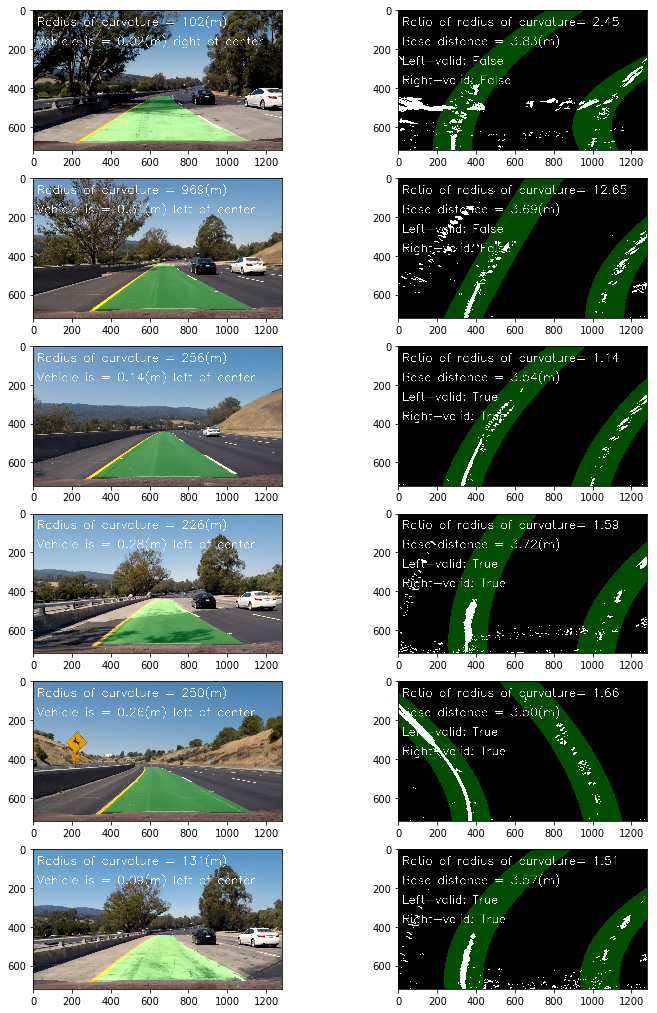

In [9]:
test_images = glob.glob('test_images/test*.jpg')
n = len(test_images)
plt.figure(figsize=(12,n*3))
grid = gs.GridSpec(n,2)

for idx, img_file in enumerate(test_images):
    #create lanes, analyse each image independently
    ll = Line(sample_img.shape[:2])
    rl = Line(sample_img.shape[:2])
    # read in image
    img = mpimg.imread(img_file)
    # plot image
    ax = plt.subplot(grid[idx*2])
    ax.imshow(process_image(img))
    # plot transformed image
    ax = plt.subplot(grid[(idx*2)+1])
    # process image
    ax.imshow(process_image(img, debug=True))

In [10]:
#create lanes
ll = Line(sample_img.shape[:2])
rl = Line(sample_img.shape[:2])

regular_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
regular_clip = clip1.fl_image(process_image) 

%time regular_clip.write_videofile(regular_output, audio=False);

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [12:07<00:00,  1.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 8min 59s, sys: 59.3 s, total: 9min 58s
Wall time: 12min 10s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(regular_output))

# saving test images

In [15]:
clip = VideoFileClip("project_video.mp4")
for t in range(7):
    clip.save_frame("frame_sample{}.png".format(t), t=t)

In [16]:
from PIL import Image

for infile in glob.glob('frame_sample*.png'):
#for infile in glob.glob('frame_sample*.png'):
    outfile = infile.replace('.png', '.jpg')
    im = Image.open(infile)
    im.convert('RGB').save(outfile, 'JPEG')

In [17]:
def preprocess(img):
    #color
    color_binary = color_thresh(img, thresh=(150,255))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #gradient
    gradx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=5, thresh=(40,100))
    grady_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=7, thresh=(40,100))
    mag_binary = mag_thresh(gray, sobel_kernel=15, thresh=(20,100))

    combined = np.zeros_like(gray)
    combined[((gradx_binary == 1) & (grady_binary == 1) & (mag_binary == 1)) | (color_binary==1)] = 1
    return combined

In [13]:
#for challenging video
ll = Line(sample_img.shape[:2])
rl = Line(sample_img.shape[:2])

regular_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
regular_clip = clip1.fl_image(process_image) 

%time regular_clip.write_videofile(regular_output, audio=False);

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [03:57<00:00,  2.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 52s, sys: 18.6 s, total: 3min 11s
Wall time: 4min


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(regular_output))

In [15]:
ll = Line(sample_img.shape[:2])
rl = Line(sample_img.shape[:2])

regular_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip('harder_challenge_video.mp4')
regular_clip = clip1.fl_image(process_image) 

%time regular_clip.write_videofile(regular_output, audio=False);

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [10:06<00:00,  1.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 7min 18s, sys: 11.4 s, total: 7min 29s
Wall time: 10min 11s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(regular_output))